In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import copy

import SimpleITK as sitk

from pathlib import Path
from collections import defaultdict
from typing import Any, Dict, Iterable, List, Tuple, Sequence

from dataclasses import dataclass, replace
from itertools import product

try:
    from IPython.display import display
except ImportError:  # pragma: no cover - fallback when running as a script
    def display(obj):
        print(obj)

from omegaconf import DictConfig, OmegaConf
from scipy.ndimage import gaussian_filter

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

import tg43.rtstruct_export as rtexport
import src.dataloader as dataloader

import matplotlib.colors as mcolors


In [2]:
def get_reference_point(dose_ref_points: Dict[str, Any], label: str) -> Dict[str, Any]:
    for entry in dose_ref_points:
        if entry["description"].strip().lower() == label.lower():
            return entry
    raise ValueError(f"{label} reference point not found in RTPLAN.")


def filter_redundant_positions(positions: Iterable[np.ndarray]) -> np.ndarray:
    seen = set()
    unique = []
    for pos in positions:
        if pos is None:
            continue
        arr = np.asarray(pos, dtype=float)
        key = tuple(arr.tolist())
        if key in seen:
            continue
        seen.add(key)
        unique.append(arr)
    if not unique:
        return np.zeros((0, 3), dtype=float)
    return np.vstack(unique)


def compute_reference_point_clouds(
    rt_channels,
    aux_points: Dict[str, Any],
) -> Dict[str, np.ndarray]:
    """Return left/right ovoid and tandem reference point sets in centimetres."""
    if len(rt_channels) < 3:
        raise ValueError("Expected at least 3 channels (left/right ovoid + tandem).")

    pos_ovoid_left = filter_redundant_positions(rt_channels[0].positions_cm)
    pos_ovoid_right = filter_redundant_positions(rt_channels[1].positions_cm)
    pos_tandem = filter_redundant_positions(rt_channels[2].positions_cm)

    if not pos_ovoid_left.size or not pos_ovoid_right.size or not pos_tandem.size:
        raise ValueError("Missing dwell positions for ovoid/tandem channels.")

    if '13' in aux_points["rtplan_description"]:
        offset_to_ovoid_surface = 0.75
        offset_over_ovoid_surface = 0.5
        offset_tandem = 2.0
    else: # other cases
        offset_to_ovoid_surface = 0.8
        offset_over_ovoid_surface = 0.5
        offset_tandem = 2.0

    alt_point = get_reference_point(aux_points["dose_reference_points"], "Alt")
    art_point = get_reference_point(aux_points["dose_reference_points"], "Art")
    pos_a_left = np.asarray(alt_point["positions_cm"], dtype=float)
    pos_a_right = np.asarray(art_point["positions_cm"], dtype=float)

    def _unit_vector(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm <= 0.0:
            raise ValueError("Encountered zero-length vector while normalising reference axes.")
        return vec / norm

    ovoid_center = (np.mean(pos_ovoid_right, axis=0) + np.mean(pos_ovoid_left, axis=0)) / 2
    ovoid_axis = np.mean(pos_ovoid_right, axis=0) - np.mean(pos_ovoid_left, axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]

    ovoid_dir = _unit_vector(ovoid_axis)
    tandem_dir = _unit_vector(tandem_axis)
    dot_val = float(np.clip(np.dot(ovoid_dir, tandem_dir), -1.0, 1.0))
    angle_deg = np.degrees(np.arccos(dot_val))
    print(f"Angle between ovoid and tandem axes: {angle_deg:.2f} deg")

    ref_ovoid_surface_left = pos_ovoid_left - (ovoid_dir * offset_to_ovoid_surface)
    ref_ovoid_surface_right = pos_ovoid_right + (ovoid_dir * offset_to_ovoid_surface)
    ref_ovoid_left = pos_ovoid_left - (ovoid_dir * (offset_to_ovoid_surface + offset_over_ovoid_surface))
    ref_ovoid_right = pos_ovoid_right + (ovoid_dir * (offset_to_ovoid_surface + offset_over_ovoid_surface))

    ref_tandem_left = pos_tandem - (ovoid_dir * offset_tandem)
    ref_tandem_right = pos_tandem + (ovoid_dir * offset_tandem)

    threshold_distance = 0.5
    mask = np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance
    ref_tandem_left = ref_tandem_left[mask]
    ref_tandem_right = ref_tandem_right[mask]

    def _filter_by_point_a(ref_pts: np.ndarray, point_a: np.ndarray) -> np.ndarray:
        if ref_pts.shape[0] < 2:
            return ref_pts
        delta_cm = ref_pts - point_a
        axis = ref_pts[-1] - ref_pts[0]
        axis_norm = np.linalg.norm(axis)
        if axis_norm <= 0.0:
            return ref_pts
        axis = axis / axis_norm
        proj_mm = (delta_cm @ axis) * 10.0
        keep = proj_mm <= 5.0
        return ref_pts[keep]

    ref_tandem_left = _filter_by_point_a(ref_tandem_left[1:], pos_a_left)
    ref_tandem_right = _filter_by_point_a(ref_tandem_right[1:], pos_a_right)

    def _slice_points(points: np.ndarray) -> np.ndarray:
        if points.shape[0] >= 3:
            return points[1:3]
        if points.shape[0] <= 1:
            return points
        return points[1:]

    ovoid_surface_left = _slice_points(ref_ovoid_surface_left)
    ovoid_surface_right = _slice_points(ref_ovoid_surface_right)
    ovoid_5mm_left = _slice_points(ref_ovoid_left)
    ovoid_5mm_right = _slice_points(ref_ovoid_right)

    return {
        "ovoid_surface_left": ovoid_surface_left,
        "ovoid_surface_right": ovoid_surface_right,
        "ovoid_5mm_left": ovoid_5mm_left,
        "ovoid_5mm_right": ovoid_5mm_right,
        "ref_tandem_left": ref_tandem_left,
        "ref_tandem_right": ref_tandem_right,
    }


def compute_influence_matrix(
    dwells: List[dosecal.DwellPoint],
    ref_points_cm: np.ndarray,
    tables: dosecal.TG43TableSet,
) -> np.ndarray:
    pts = np.asarray(ref_points_cm, dtype=float)
    if pts.size == 0:
        return np.zeros((0, len(dwells)))
    influence = np.zeros((pts.shape[0], len(dwells)))
    for idx, dwell in enumerate(dwells):
        influence[:, idx] = (
            dosecal.compute_tg43_dose_at_points(
                [dwell], pts, tables, dwell_time_override_s=1.0
            )  # convert Gy per second to cGy per second
        )
    return influence


def build_reference_constraints(
    ref_sets: Dict[str, np.ndarray],
    dwells: List[dosecal.DwellPoint],
    tables: dosecal.TG43TableSet,
    prescription_dose_cgy: float,
) -> Tuple[Dict[str, Dict[str, Any]], List[Dict[str, Any]]]:
    def _group_from_label(label: str) -> str:
        name = label.lower()
        if "tandem" in name:
            return "tandem"
        if "surface" in name:
            return "ovoid_surface"
        if "5mm" in name:
            return "ovoid_5mm"
        raise ValueError(f"Unable to classify reference label '{label}'.")

    specs = {
        "tandem": {"target_scale": 1.0, "sense": "lower_bound"},
        "ovoid_surface": {"target_scale": 1.4, "sense": "upper_bound"},
        "ovoid_5mm": {"sense": "eqd2_upper"},
    }
    grouped: Dict[str, Dict[str, Any]] = defaultdict(
        lambda: {"matrix_rows": [], "targets": [], "rows": []}
    )
    rows: List[Dict[str, Any]] = []
    for label, points in ref_sets.items():
        pts = np.asarray(points, dtype=float)
        if pts.size == 0:
            continue
        group = _group_from_label(label)
        influence = compute_influence_matrix(dwells, pts, tables)
        entry = grouped[group]
        entry["matrix_rows"].append(influence)
        target_val = None
        target_scale = specs[group].get("target_scale")
        if target_scale is not None:
            target_val = prescription_dose_cgy * target_scale
            entry["targets"].append(np.full(pts.shape[0], target_val))
        for idx in range(pts.shape[0]):
            record = {
                "group": group,
                "subset": label,
                "point_index": idx,
                "point_cm": pts[idx].tolist(),
                "constraint_kind": specs[group]["sense"],
                "target_dose_cgy": target_val if target_val is not None else float("nan"),
            }
            entry["rows"].append(record)
            rows.append(record)

    constraint_groups: Dict[str, Dict[str, Any]] = {}
    for group, entry in grouped.items():
        matrix = (
            np.vstack(entry["matrix_rows"]) if entry["matrix_rows"] else np.zeros((0, len(dwells)))
        )
        targets = (
            np.concatenate(entry["targets"]) if entry["targets"] else None
        )
        constraint_groups[group] = {
            "matrix": matrix,
            "target": targets,
            "rows": entry["rows"],
        }
    return constraint_groups, rows
@dataclass
class ApplicatorFrame:
    rotation: np.ndarray
    translation_mm: np.ndarray
    anchor_mm: np.ndarray
    description: str = "ECS"

    @property
    def inverse_rotation(self) -> np.ndarray:
        return self.rotation.T

    def transform_points_mm(self, pts_mm):
        arr = np.asarray(pts_mm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        orig_shape = arr.shape
        arr = arr.reshape(-1, 3)
        transformed = (self.rotation @ arr.T).T + self.translation_mm
        return transformed.reshape(orig_shape)

    def inverse_transform_points_mm(self, pts_mm):
        arr = np.asarray(pts_mm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        orig_shape = arr.shape
        arr = arr.reshape(-1, 3)
        restored = (self.inverse_rotation @ (arr - self.translation_mm).T).T
        return restored.reshape(orig_shape)

    def transform_points_cm(self, pts_cm):
        arr = np.asarray(pts_cm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        return self.transform_points_mm(arr * 10.0) / 10.0

    def inverse_transform_points_cm(self, pts_cm):
        arr = np.asarray(pts_cm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        restored = self.inverse_transform_points_mm(arr * 10.0)
        return restored / 10.0

def build_ecs_coordinate_frame(
    rt_channels,
    aux_points,
    *,
    plane_offset_mm: float = 20.0,
) -> ApplicatorFrame:
    if len(rt_channels) < 3:
        raise ValueError("Need at least 3 channels (two ovoids + tandem) to define ECS frame.")

    def _nonnull_positions(channel):
        coords = [np.asarray(p, dtype=float) for p in channel.positions_cm if p is not None]
        if not coords:
            raise ValueError("Channel is missing dwell positions.")
        arr = np.vstack(coords)
        if arr.shape[1] != 3:
            raise ValueError("Expected 3-D dwell positions.")
        return arr

    def _unit(vec, label):
        norm = np.linalg.norm(vec)
        if norm <= 0.0:
            raise ValueError(f"Encountered zero-length vector while building {label} axis.")
        return vec / norm

    ovoid_left_cm = _nonnull_positions(rt_channels[0])
    ovoid_right_cm = _nonnull_positions(rt_channels[1])
    tandem_positions_cm = _nonnull_positions(rt_channels[2])
    if tandem_positions_cm.shape[0] < 2:
        raise ValueError("Tandem channel must have at least two dwell positions.")
    ovoid_left_centroid_mm = np.mean(ovoid_left_cm, axis=0) * 10.0
    ovoid_right_centroid_mm = np.mean(ovoid_right_cm, axis=0) * 10.0
    tandem_positions_mm = tandem_positions_cm * 10.0

    art_point = get_reference_point(aux_points["dose_reference_points"], "Art")
    alt_point = get_reference_point(aux_points["dose_reference_points"], "Alt")
    art_mm = np.asarray(art_point["positions_cm"], dtype=float) * 10.0
    alt_mm = np.asarray(alt_point["positions_cm"], dtype=float) * 10.0
    point_a_axis = alt_mm - art_mm

    z_axis = _unit(tandem_positions_mm[0] - tandem_positions_mm[-1], "z")

    ovoid_axis_mm = ovoid_right_centroid_mm - ovoid_left_centroid_mm
    lateral_component = ovoid_axis_mm - np.dot(ovoid_axis_mm, z_axis) * z_axis
    if np.linalg.norm(lateral_component) <= 1e-6:
        x_axis = _unit(point_a_axis, "x (Point A)")
    else:
        x_axis = _unit(lateral_component, "x (ovoid span)")
    if np.dot(x_axis, point_a_axis) < 0:
        x_axis = -x_axis

    y_axis = _unit(np.cross(z_axis, x_axis), "y")
    x_axis = _unit(np.cross(y_axis, z_axis), "x")

    rotation = np.vstack([x_axis, y_axis, z_axis])

    plane_normal = z_axis
    plane_d = float(np.dot(plane_normal, art_mm))
    line_vec = tandem_positions_mm[-1] - tandem_positions_mm[0]
    denom = float(np.dot(plane_normal, line_vec))
    if abs(denom) <= 1e-6:
        t_plane = 0.0
    else:
        t_plane = (plane_d - float(np.dot(plane_normal, tandem_positions_mm[0]))) / denom
    intersection_mm = tandem_positions_mm[0] + t_plane * line_vec

    target_mm = np.array([0.0, 0.0, float(plane_offset_mm)], dtype=float)
    translation_mm = target_mm - rotation @ intersection_mm

    return ApplicatorFrame(
        rotation=rotation,
        translation_mm=translation_mm,
        anchor_mm=intersection_mm,
        description="ECS",
    )
def transform_channels_to_frame(channels, frame: ApplicatorFrame):
    transformed = []
    for channel in channels:
        new_positions = []
        for pos in channel.positions_cm:
            if pos is None:
                new_positions.append(None)
            else:
                new_positions.append(frame.transform_points_cm(pos))
        transformed.append(replace(channel, positions_cm=new_positions))
    return transformed

def transform_point_sets(point_sets, frame: ApplicatorFrame):
    transformed = {}
    for label, pts in point_sets.items():
        arr = np.asarray(pts, dtype=float)
        if arr.size == 0:
            transformed[label] = arr.copy()
            continue
        transformed[label] = frame.transform_points_cm(arr)
    return transformed

def resample_image_to_frame(
    image,
    frame: ApplicatorFrame,
    *,
    spacing_mm=1.0,
    margin_mm: float = 5.0,
    default_value: float = -1024.0,
):
    if np.isscalar(spacing_mm):
        spacing_vals = np.array([float(spacing_mm)] * 3, dtype=float)
    else:
        spacing_vals = np.array(list(spacing_mm), dtype=float)
    if spacing_vals.size != 3:
        raise ValueError("spacing_mm must provide 3 values.")
    if np.any(spacing_vals <= 0):
        raise ValueError("Output spacing must be positive.")

    size = np.array(image.GetSize(), dtype=float)
    spacing = np.array(image.GetSpacing(), dtype=float)
    direction = np.array(image.GetDirection(), dtype=float).reshape(3, 3)
    origin = np.array(image.GetOrigin(), dtype=float)

    corners = []
    for idx in product([0, max(size[0] - 1, 0)], [0, max(size[1] - 1, 0)], [0, max(size[2] - 1, 0)]):
        idx_vec = np.array(idx, dtype=float)
        coord = origin + direction @ (spacing * idx_vec)
        corners.append(coord)
    corners = np.array(corners)
    if not corners.size:
        corners = origin[None, :]

    corners_ecs = frame.transform_points_mm(corners)
    mins = corners_ecs.min(axis=0) - margin_mm
    maxs = corners_ecs.max(axis=0) + margin_mm
    extent = np.maximum(maxs - mins, spacing_vals)
    out_size = np.maximum(np.ceil(extent / spacing_vals).astype(int), 1)

    inv_rotation = frame.inverse_rotation
    inv_translation = -inv_rotation @ frame.translation_mm
    transform = sitk.AffineTransform(3)
    transform.SetMatrix(tuple(inv_rotation.reshape(-1)))
    transform.SetTranslation(tuple(inv_translation.tolist()))

    direction_out = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
    resampled_image = sitk.Resample(
        image,
        tuple(int(v) for v in out_size.tolist()),
        transform,
        sitk.sitkLinear,
        tuple(mins.tolist()),
        tuple(spacing_vals.tolist()),
        direction_out,
        float(default_value),
        image.GetPixelIDValue(),
    )
    resampled_array = sitk.GetArrayFromImage(resampled_image)
    metadata = {
        "spacing": resampled_image.GetSpacing(),
        "origin": resampled_image.GetOrigin(),
        "direction": resampled_image.GetDirection(),
        "size": resampled_image.GetSize(),
    }
    return resampled_image, resampled_array, metadata

In [3]:
STRUCTURES = ("Bladder", "Rectum", "Sigmoid", "Bowel", "HR-CTV")

# T&O

In [4]:
path_case = Path("/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = list(path_case.glob("RTPLAN*/*/*.dcm"))[0]
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]

ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels, aux_points = dhelp.load_rtplan_by_channel(path_rt_plan, all_points=True)
reference_sets = compute_reference_point_clouds(rt_channels, aux_points)

applicator_frame = build_ecs_coordinate_frame(rt_channels, aux_points, plane_offset_mm=20.0)
rt_channels_ecs = transform_channels_to_frame(rt_channels, applicator_frame)
reference_sets_ecs = transform_point_sets(reference_sets, applicator_frame)

reference_points_native = {
    entry["description"]: np.asarray(entry["positions_cm"], dtype=float)
    for entry in aux_points["dose_reference_points"]
    if entry.get("positions_cm") is not None
}
reference_points_ecs = {
    label: applicator_frame.transform_points_cm(pos)
    for label, pos in reference_points_native.items()
}

default_hu = float(np.min(ct_array)) if ct_array is not None else -1024.0
ct_ecs_image, ct_ecs_array, ct_ecs_metadata = resample_image_to_frame(
    ct_image,
    applicator_frame,
    spacing_mm=1.0,
    margin_mm=5.0,
    default_value=default_hu,
)

print("Applicator rotation matrix (rows = X/Y/Z axes):")
print(applicator_frame.rotation)
print("Native CT size/spacing:", ct_image.GetSize(), ct_image.GetSpacing())
print("ECS CT size/spacing:", ct_ecs_image.GetSize(), ct_ecs_image.GetSpacing())

Angle between ovoid and tandem axes: 90.29 deg
Applicator rotation matrix (rows = X/Y/Z axes):
[[ 0.99569655  0.07236654 -0.0578918 ]
 [-0.04959828  0.94381195  0.32673998]
 [ 0.07828402 -0.32246254  0.94333956]]
Native CT size/spacing: (512, 512, 160) (0.80859375, 0.80859375, 2.0)
ECS CT size/spacing: (470, 525, 476) (1.0, 1.0, 1.0)


In [5]:
# Clinical case
path_case = Path("/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = list(path_case.glob("RTPLAN*/*/*.dcm"))[0]
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels_clinic = dhelp.load_rtplan_by_channel(path_rt_plan)
rtstruct = chelp.load_rtstruct(path_rt_struct)
list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV']

rtplan_result_clinic = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_clinic,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
rtplan_image_clinic = rtplan_result_clinic.resampled_image
rtplan_array_clinic = rtplan_result_clinic.resampled_array 
rtplan_meta_clinic = rtplan_result_clinic.metadata

In [6]:
# Commercial case
path_case = Path("/mnt/d/PRV/IPSA_GYN_Geneva_wo_Needles/DNU_IPSA_6")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = list(path_case.glob("RTPLAN*/*/*.dcm"))[0]
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels_commercial = dhelp.load_rtplan_by_channel(path_rt_plan)
rtstruct = chelp.load_rtstruct(path_rt_struct)
list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV']

rtplan_result_commercial = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_commercial,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
rtplan_image_commercial = rtplan_result_commercial.resampled_image
rtplan_array_commercial = rtplan_result_commercial.resampled_array 
rtplan_meta_commercial = rtplan_result_commercial.metadata

In [7]:
# In-house case
path_case = Path("/mnt/d/PRV/IPSA_GYN_Geneva_wo_Needles/DNU_IPSA_6")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = "/home/ypark6/aapm26/inverse_planning_best_models/Results_20251114_112418_IPSA_GYN_Geneva_wo_Needles_DNU_IPSA_IPSA/DNU_IPSA_6/20251114-112424_3ebe213d-5dd1-475a-afd7-5c335747a3b6/rtplan_ipsa.dcm"
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels_inhouse = dhelp.load_rtplan_by_channel(path_rt_plan)
rtstruct = chelp.load_rtstruct(path_rt_struct)
list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV']

rtplan_result_inhouse = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_inhouse,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
rtplan_image_inhouse = rtplan_result_inhouse.resampled_image
rtplan_array_inhouse = rtplan_result_inhouse.resampled_array 
rtplan_meta_inhouse = rtplan_result_inhouse.metadata

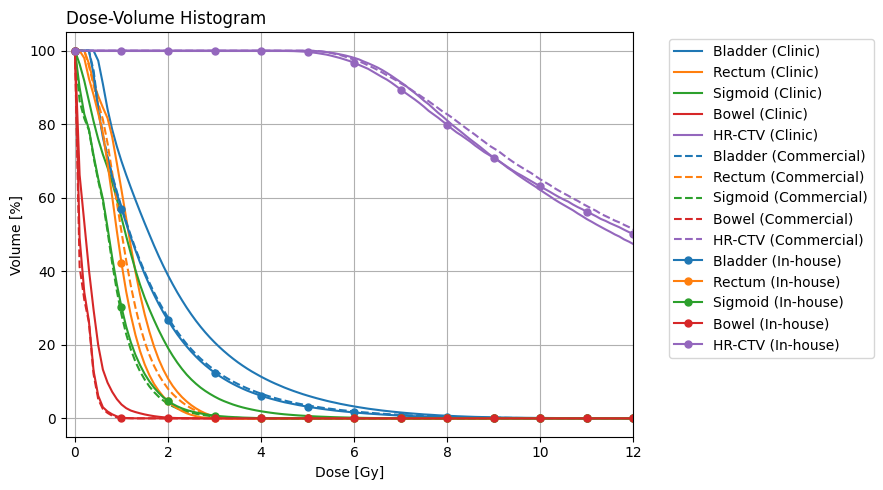

In [8]:
list_colors = list(mcolors.TABLEAU_COLORS.values())
color_cnt = 0

dvh_python_clinic = dosecal.calculate_dvh(
    rtstruct,
    ct_image,
    rtplan_result_clinic,
    structures=STRUCTURES,
)
dvh_python_commercial = dosecal.calculate_dvh(
    rtstruct,
    ct_image,
    rtplan_result_commercial,
    structures=STRUCTURES,
)
dvh_python_inhouse = dosecal.calculate_dvh(
    rtstruct,
    ct_image,
    rtplan_result_inhouse,
    structures=STRUCTURES,
)


x_start, x_end = -0.2, 12
plt.figure(figsize=(9, 5), dpi=100)

colours = list(mcolors.TABLEAU_COLORS.values())
for idx, name in enumerate(list_contour):
    plt.plot(
        dvh_python_clinic[name].dose_bins_Gy,
        dvh_python_clinic[name].volume_percent,
        color=colours[idx],
        linewidth=1.5,
        linestyle="-",
        label=f"{name} (Clinic)",
    )
for idx, name in enumerate(list_contour):
    plt.plot(
        dvh_python_commercial[name].dose_bins_Gy,
        dvh_python_commercial[name].volume_percent,
        color=colours[idx],
        linewidth=1.5,
        linestyle="--",
        label=f"{name} (Commercial)",
    )
for idx, name in enumerate(list_contour):
    plt.plot(
        dvh_python_inhouse[name].dose_bins_Gy,
        dvh_python_inhouse[name].volume_percent,
        color=colours[idx],
        linewidth=1.5,
        linestyle="-",
        marker='o', markersize=5, markevery=10,
        label=f"{name} (In-house)",
    )

plt.title("Dose-Volume Histogram", loc='left')
plt.xlabel("Dose [Gy]")
plt.ylabel("Volume [%]")
plt.xlim(x_start, x_end)
# plt.ylim(60, 100)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
rt_channels_clinic_ecs = transform_channels_to_frame(rt_channels_clinic, applicator_frame)
rt_channels_commercial_ecs = transform_channels_to_frame(rt_channels_commercial, applicator_frame)
rt_channels_inhouse_ecs = transform_channels_to_frame(rt_channels_inhouse, applicator_frame)

dose_ecs_clinic = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=rt_channels_clinic_ecs,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
dose_ecs_commercial = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=rt_channels_commercial_ecs,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
dose_ecs_inhouse = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=rt_channels_inhouse_ecs,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)

600 [ 300.  600. 1200.]


/tmp/ipykernel_297146/2724401981.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


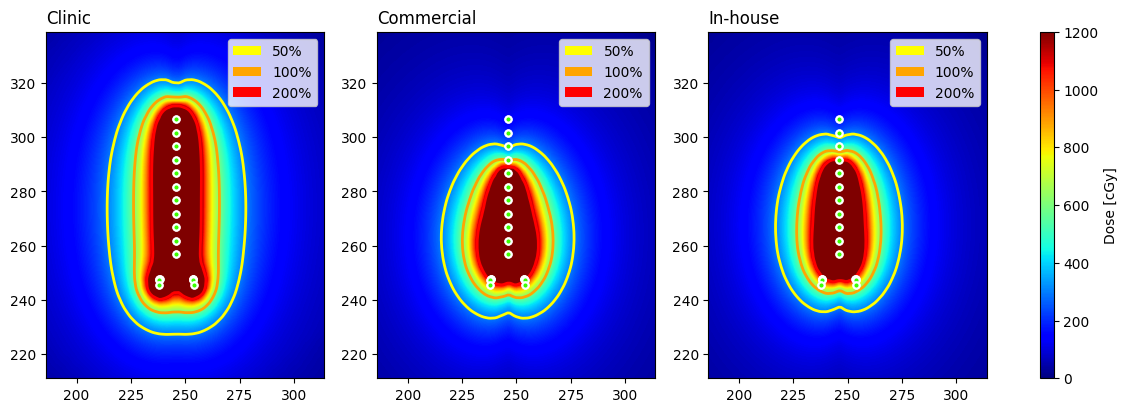

In [10]:

prescription_dose_cgy = 600  # cGy
x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(np.array(x_ticks) * ct_ecs_metadata["spacing"][0], dtype=int)
y_coords_mm = np.array(np.array(y_ticks) * ct_ecs_metadata["spacing"][1], dtype=int)
z_coords_mm = np.array(np.array(z_ticks) * ct_ecs_metadata["spacing"][2], dtype=int)

vmin, vmax = 0, prescription_dose_cgy * 2
iso_levels = np.array([0.5, 1.0, 2.0]) * prescription_dose_cgy  # cGy
iso_colors = ["yellow","orange","red"]
iso_labels = ['50%', '100%', '200%']
print(prescription_dose_cgy, iso_levels)

fontsize = 8 
tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

fig = plt.figure(figsize=(13, 4.5), dpi=100)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25)
axes = [fig.add_subplot(gs[0, idx]) for idx in range(3)]
cbar_ax = fig.add_subplot(gs[0, 3])

dose_views = [
    ("Clinic", dose_ecs_clinic.resampled_array),
    ("Commercial", dose_ecs_commercial.resampled_array),
    ("In-house", dose_ecs_inhouse.resampled_array),
]

dwell_info = dhelp.extract_dwell_positions_continuous_index(ct_ecs_image, rt_channels_clinic_ecs)
dwell_positions = np.array(dwell_info['position'])
display_offet = 1.5
x_center = 250
y_center = 275
size_zoom_x = 128
size_zoom_y = 128

im = None
for ax, (title, dose_array) in zip(axes, dose_views):
    view_coronal = dose_array[:, np.argmax(np.sum(dose_array, axis=(0, 2))), :]
    im = ax.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax, zorder=1)
    ax.contour(view_coronal, levels=iso_levels, colors=iso_colors, linewidths=2.0, zorder=2)
    proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
    ax.legend(proxy, iso_labels)
    ax.scatter(dwell_positions[:, 0]-display_offet, dwell_positions[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#3cff00", zorder=3)
    ax.set_xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
    ax.set_ylim(y_center-size_zoom_y//2, y_center+size_zoom_y//2)
    ax.set_title(title, loc='left')

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Dose [cGy]")
plt.tight_layout()
plt.show()


# T&O+N

In [11]:
path_case = Path("/mnt/d/PRV/GYN_Geneva_with_Needles/CaseGWN4")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = list(path_case.glob("RTPLAN*/*/*.dcm"))[0]
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]

ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels, aux_points = dhelp.load_rtplan_by_channel(path_rt_plan, all_points=True)
reference_sets = compute_reference_point_clouds(rt_channels, aux_points)

applicator_frame = build_ecs_coordinate_frame(rt_channels, aux_points, plane_offset_mm=20.0)
rt_channels_ecs = transform_channels_to_frame(rt_channels, applicator_frame)
reference_sets_ecs = transform_point_sets(reference_sets, applicator_frame)

reference_points_native = {
    entry["description"]: np.asarray(entry["positions_cm"], dtype=float)
    for entry in aux_points["dose_reference_points"]
    if entry.get("positions_cm") is not None
}
reference_points_ecs = {
    label: applicator_frame.transform_points_cm(pos)
    for label, pos in reference_points_native.items()
}

default_hu = float(np.min(ct_array)) if ct_array is not None else -1024.0
ct_ecs_image, ct_ecs_array, ct_ecs_metadata = resample_image_to_frame(
    ct_image,
    applicator_frame,
    spacing_mm=1.0,
    margin_mm=5.0,
    default_value=default_hu,
)

print("Applicator rotation matrix (rows = X/Y/Z axes):")
print(applicator_frame.rotation)
print("Native CT size/spacing:", ct_image.GetSize(), ct_image.GetSpacing())
print("ECS CT size/spacing:", ct_ecs_image.GetSize(), ct_ecs_image.GetSpacing())

Angle between ovoid and tandem axes: 90.00 deg
Applicator rotation matrix (rows = X/Y/Z axes):
[[ 0.99474353  0.0750591  -0.06965236]
 [-0.04661744  0.9375908   0.34460165]
 [ 0.0911709  -0.33954325  0.93616144]]
Native CT size/spacing: (512, 512, 329) (0.78125, 0.78125, 1.0)
ECS CT size/spacing: (460, 516, 490) (1.0, 1.0, 1.0)


In [12]:
# Clinical case
path_case = Path("/mnt/d/PRV/GYN_Geneva_with_Needles/CaseGWN4")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = list(path_case.glob("RTPLAN*/*/*.dcm"))[0]
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels_clinic = dhelp.load_rtplan_by_channel(path_rt_plan)
rtstruct = chelp.load_rtstruct(path_rt_struct)
list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV']

rtplan_result_clinic = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_clinic,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
rtplan_image_clinic = rtplan_result_clinic.resampled_image
rtplan_array_clinic = rtplan_result_clinic.resampled_array 
rtplan_meta_clinic = rtplan_result_clinic.metadata

In [13]:
# Commercial case
path_case = Path("/mnt/d/PRV/HIPO_GYN_Geneva_with_Needles/DNU_HIPO_4")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = list(path_case.glob("RTPLAN*/*/*.dcm"))[0]
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels_commercial = dhelp.load_rtplan_by_channel(path_rt_plan)
rtstruct = chelp.load_rtstruct(path_rt_struct)
list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV']

rtplan_result_commercial = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_commercial,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
rtplan_image_commercial = rtplan_result_commercial.resampled_image
rtplan_array_commercial = rtplan_result_commercial.resampled_array 
rtplan_meta_commercial = rtplan_result_commercial.metadata

In [14]:
# In-house case
path_case = Path("/mnt/d/PRV/HIPO_GYN_Geneva_with_Needles/DNU_HIPO_4")

path_ct = list(path_case.glob("CT*/*"))[0]
path_rt_dose = list(path_case.glob("RTDOSE*/*/*.dcm"))[0]
path_rt_plan = "/home/ypark6/aapm26/inverse_planning_best_models/Results_20251114_112623_HIPO_GYN_Geneva_with_Needles_DNU_HIPO_HIPO/DNU_HIPO_4/20251114-112638_b5bbd291-3734-4adb-8f50-a9741829b942/rtplan_hipo.dcm"
path_rt_struct = list(path_case.glob("RTSTRUCT*/*/*.dcm"))[0]
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(path_ct)
rt_channels_inhouse = dhelp.load_rtplan_by_channel(path_rt_plan)
rtstruct = chelp.load_rtstruct(path_rt_struct)
list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV']

rtplan_result_inhouse = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_inhouse,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
rtplan_image_inhouse = rtplan_result_inhouse.resampled_image
rtplan_array_inhouse = rtplan_result_inhouse.resampled_array 
rtplan_meta_inhouse = rtplan_result_inhouse.metadata

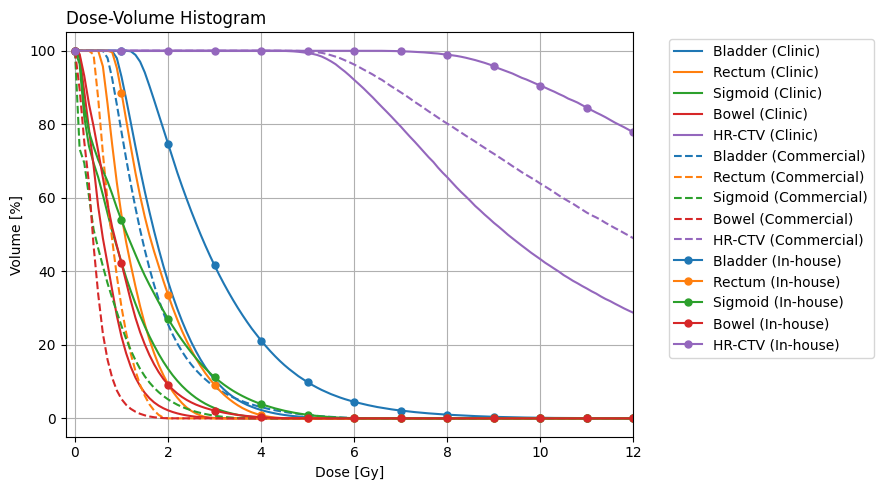

In [15]:
list_colors = list(mcolors.TABLEAU_COLORS.values())
color_cnt = 0

dvh_python_clinic = dosecal.calculate_dvh(
    rtstruct,
    ct_image,
    rtplan_result_clinic,
    structures=STRUCTURES,
)
dvh_python_commercial = dosecal.calculate_dvh(
    rtstruct,
    ct_image,
    rtplan_result_commercial,
    structures=STRUCTURES,
)
dvh_python_inhouse = dosecal.calculate_dvh(
    rtstruct,
    ct_image,
    rtplan_result_inhouse,
    structures=STRUCTURES,
)


x_start, x_end = -0.2, 12
plt.figure(figsize=(9, 5), dpi=100)

colours = list(mcolors.TABLEAU_COLORS.values())
for idx, name in enumerate(list_contour):
    plt.plot(
        dvh_python_clinic[name].dose_bins_Gy,
        dvh_python_clinic[name].volume_percent,
        color=colours[idx],
        linewidth=1.5,
        linestyle="-",
        label=f"{name} (Clinic)",
    )
for idx, name in enumerate(list_contour):
    plt.plot(
        dvh_python_commercial[name].dose_bins_Gy,
        dvh_python_commercial[name].volume_percent,
        color=colours[idx],
        linewidth=1.5,
        linestyle="--",
        label=f"{name} (Commercial)",
    )
for idx, name in enumerate(list_contour):
    plt.plot(
        dvh_python_inhouse[name].dose_bins_Gy,
        dvh_python_inhouse[name].volume_percent,
        color=colours[idx],
        linewidth=1.5,
        linestyle="-",
        marker='o', markersize=5, markevery=10,
        label=f"{name} (In-house)",
    )

plt.title("Dose-Volume Histogram", loc='left')
plt.xlabel("Dose [Gy]")
plt.ylabel("Volume [%]")
plt.xlim(x_start, x_end)
# plt.ylim(60, 100)
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
rt_channels_clinic_ecs = transform_channels_to_frame(rt_channels_clinic, applicator_frame)
rt_channels_commercial_ecs = transform_channels_to_frame(rt_channels_commercial, applicator_frame)
rt_channels_inhouse_ecs = transform_channels_to_frame(rt_channels_inhouse, applicator_frame)

dose_ecs_clinic = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=rt_channels_clinic_ecs,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
dose_ecs_commercial = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=rt_channels_commercial_ecs,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)
dose_ecs_inhouse = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=rt_channels_inhouse_ecs,
    anisotropy_path="ESTRO/nucletron_mhdr-v2_F.xlsx",
    radial_path="ESTRO/nucletron_mhdr-v2_gL.xlsx",
    grid_spacing_mm=3,
    margin_mm=20.0,
    max_distance_cm=10.0,
)

prescription_dose_cgy = 600  # cGy
x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(np.array(x_ticks) * ct_ecs_metadata["spacing"][0], dtype=int)
y_coords_mm = np.array(np.array(y_ticks) * ct_ecs_metadata["spacing"][1], dtype=int)
z_coords_mm = np.array(np.array(z_ticks) * ct_ecs_metadata["spacing"][2], dtype=int)

vmin, vmax = 0, prescription_dose_cgy * 2
iso_levels = np.array([0.5, 1.0, 2.0]) * prescription_dose_cgy  # cGy
iso_colors = ["yellow","orange","red"]
iso_labels = ['50%', '100%', '200%']
print(prescription_dose_cgy, iso_levels)

fontsize = 8 
tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

fig = plt.figure(figsize=(13, 4.5), dpi=100)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25)
axes = [fig.add_subplot(gs[0, idx]) for idx in range(3)]
cbar_ax = fig.add_subplot(gs[0, 3])

dose_views = [
    ("Clinic", dose_ecs_clinic.resampled_array),
    ("Commercial", dose_ecs_commercial.resampled_array),
    ("In-house", dose_ecs_inhouse.resampled_array),
]

dwell_info = dhelp.extract_dwell_positions_continuous_index(ct_ecs_image, rt_channels_clinic_ecs)
dwell_positions = np.array(dwell_info['position'])
display_offet = 1.5
x_center = 250
y_center = 295
size_zoom_x = 128
size_zoom_y = 128

im = None
for ax, (title, dose_array) in zip(axes, dose_views):
    view_coronal = dose_array[:, np.argmax(np.sum(dose_array, axis=(0, 2))), :]
    im = ax.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax, zorder=1)
    ax.contour(view_coronal, levels=iso_levels, colors=iso_colors, linewidths=2.0, zorder=2)
    proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
    ax.legend(proxy, iso_labels)
    ax.scatter(dwell_positions[:, 0]-display_offet, dwell_positions[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#3cff00", zorder=3)
    ax.set_xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
    ax.set_ylim(y_center-size_zoom_y//2, y_center+size_zoom_y//2)
    ax.set_title(title, loc='left')

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Dose [cGy]")
plt.tight_layout()
plt.show()


600 [ 300.  600. 1200.]


/tmp/ipykernel_297146/3724009288.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


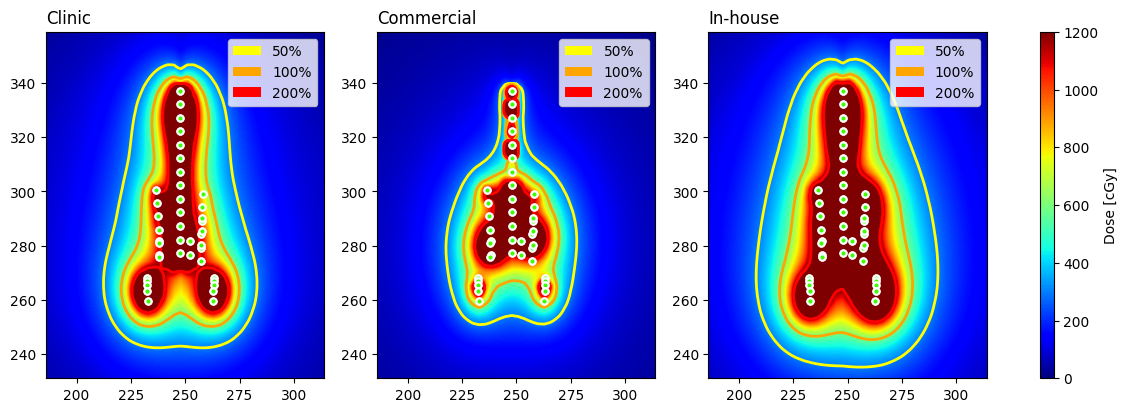

In [ ]:
prescription_dose_cgy = 600  # cGy
x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(np.array(x_ticks) * ct_ecs_metadata["spacing"][0], dtype=int)
y_coords_mm = np.array(np.array(y_ticks) * ct_ecs_metadata["spacing"][1], dtype=int)
z_coords_mm = np.array(np.array(z_ticks) * ct_ecs_metadata["spacing"][2], dtype=int)

vmin, vmax = 0, prescription_dose_cgy * 2
iso_levels = np.array([0.5, 1.0, 2.0]) * prescription_dose_cgy  # cGy
iso_colors = ["yellow","orange","red"]
iso_labels = ['50%', '100%', '200%']
print(prescription_dose_cgy, iso_levels)

fontsize = 8 
tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

fig = plt.figure(figsize=(13, 4.5), dpi=100)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.25)
axes = [fig.add_subplot(gs[0, idx]) for idx in range(3)]
cbar_ax = fig.add_subplot(gs[0, 3])

dose_views = [
    ("Clinic", dose_ecs_clinic.resampled_array),
    ("Commercial", dose_ecs_commercial.resampled_array),
    ("In-house", dose_ecs_inhouse.resampled_array),
]

dwell_info = dhelp.extract_dwell_positions_continuous_index(ct_ecs_image, rt_channels_clinic_ecs)
dwell_positions = np.array(dwell_info['position'])
display_offet = 1.5
x_center = 250
y_center = 295
size_zoom_x = 128
size_zoom_y = 128

im = None
for ax, (title, dose_array) in zip(axes, dose_views):
    view_coronal = dose_array[:, np.argmax(np.sum(dose_array, axis=(0, 2))), :]
    im = ax.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax, zorder=1)
    ax.contour(view_coronal, levels=iso_levels, colors=iso_colors, linewidths=2.0, zorder=2)
    proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
    ax.legend(proxy, iso_labels)
    ax.scatter(dwell_positions[:, 0]-display_offet, dwell_positions[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#3cff00", zorder=3)
    ax.set_xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
    ax.set_ylim(y_center-size_zoom_y//2, y_center+size_zoom_y//2)
    ax.set_title(title, loc='left')

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Dose [cGy]")
plt.tight_layout()
plt.show()
